In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["HF_HUB_CACHE"] = "/mnt/sda/home/zijianwang/HF_CACHE"
from collections import deque
from dataclasses import dataclass
from pathlib import Path
from typing import Optional

import draccus
import torch
import torch.distributed as dist
import tqdm
from accelerate import PartialState
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig
from transformers import AutoConfig, AutoImageProcessor
from transformers.modeling_outputs import CausalLMOutputWithPast

import wandb
from prismatic.models.backbones.llm.prompting import PurePromptBuilder, VicunaV15ChatPromptBuilder
from prismatic.util.data_utils import PaddedCollatorForActionPrediction
from prismatic.vla.action_tokenizer import ActionTokenizer
from prismatic.vla.datasets import RLDSBatchTransform, RLDSDataset, EpisodicRLDSDataset
from prismatic.vla.datasets.rlds.utils.data_utils import save_dataset_statistics

from prismatic.extern.hf.configuration_prismatic import OpenVLAConfig
from prismatic.extern.hf.modeling_prismatic import OpenVLAForActionPrediction
from prismatic.extern.hf.processing_prismatic import PrismaticImageProcessor, PrismaticProcessor

# Sane Defaults
os.environ["TOKENIZERS_PARALLELISM"] = "false"

/home/zijianwang/miniconda3/envs/openvla/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-25 21:50:45.219649: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-25 21:50:45.219683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-25 21:50:45.221464: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-25 21:50:45.230395: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
AutoConfig.register("openvla", OpenVLAConfig)
AutoImageProcessor.register(OpenVLAConfig, PrismaticImageProcessor)
AutoProcessor.register(OpenVLAConfig, PrismaticProcessor)
AutoModelForVision2Seq.register(OpenVLAConfig, OpenVLAForActionPrediction)

In [4]:
processor = AutoProcessor.from_pretrained("openvla/openvla-7b", trust_remote_code=True)

In [6]:
vla = AutoModelForVision2Seq.from_pretrained(
    "openvla/openvla-7b", 
    attn_implementation="flash_attention_2",  # [Optional] Requires `flash_attn`
    torch_dtype=torch.bfloat16, 
    low_cpu_mem_usage=True, 
    trust_remote_code=True
).to("cuda:0")

Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


In [5]:
action_tokenizer = ActionTokenizer(processor.tokenizer)
vocab_size = action_tokenizer.vocab_size
print("词表大小:", vocab_size)

词表大小: 256


In [6]:
vla_model_config = OpenVLAConfig.from_pretrained("openvla/openvla-7b")

In [7]:
print(vla_model_config.image_sizes)

[224, 224]


In [8]:
batch_transform = RLDSBatchTransform(
    action_tokenizer,
    processor.tokenizer,
    image_transform=processor.image_processor.apply_transform,
    prompt_builder_fn=PurePromptBuilder if "v01" not in "openvla/openvla-7b" else VicunaV15ChatPromptBuilder,
)

vla_dataset = RLDSDataset(
    "/mnt/sda/home/zijianwang/openvla/modified_libero_rlds",
    "libero_goal_no_noops",
    batch_transform,
    resize_resolution=tuple(vla_model_config.image_sizes),
    shuffle_buffer_size=100_000,
    image_aug=True,
)

episodic_vla_dataset = EpisodicRLDSDataset(
    "/mnt/sda/home/zijianwang/openvla/modified_libero_rlds",
    "libero_goal_no_noops",
    batch_transform,
    resize_resolution=tuple(vla_model_config.image_sizes),
    shuffle_buffer_size=100_000,
    image_aug=True,
)

2025-07-25 21:51:23.300973: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


07/25 [21:51:23] INFO     | >> [*] Loading existing dataset statistics from                       ]8;id=185882;file:///mnt/sda/home/zijianwang/openvla/prismatic/vla/datasets/rlds/utils/data_utils.py\data_utils.py]8;;\:]8;id=298209;file:///mnt/sda/home/zijianwang/openvla/prismatic/vla/datasets/rlds/utils/data_utils.py#208\208]8;;\
                          /mnt/sda/home/zijianwang/openvla/modified_libero_rlds/libero_goal_no_no                  
                          ops/1.0.0/dataset_statistics_13518c2068e319e5876a2dec0fe33c2c05e6708bcb                  
                          03b97b7fc4d5c869fa467f.json.                                                             

2025-07-25 21:51:23.861404: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization



######################################################################################
# Loading the following 1 datasets (incl. sampling weight):                         #
# libero_goal_no_noops: ====================================================1.000000 #
######################################################################################



07/25 [21:51:24] INFO     | >> [*] Threads per Dataset: [1]                                          ]8;id=885891;file:///mnt/sda/home/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py\dataset.py]8;;\:]8;id=746050;file:///mnt/sda/home/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py#533\533]8;;\

                 INFO     | >> [*] Reads per Dataset: [1]                                            ]8;id=252001;file:///mnt/sda/home/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py\dataset.py]8;;\:]8;id=507304;file:///mnt/sda/home/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py#534\534]8;;\

                 INFO     | >> [*] Constructing datasets...                                          ]8;id=200725;file:///mnt/sda/home/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py\dataset.py]8;;\:]8;id=419365;file:///mnt/sda/home/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py#537\537]8;;\

2025-07-25 21:51:24.440035: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


07/25 [21:51:25] INFO     | >> [*] Applying frame transforms on dataset...                           ]8;id=691463;file:///mnt/sda/home/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py\dataset.py]8;;\:]8;id=184700;file:///mnt/sda/home/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py#577\577]8;;\

2025-07-25 21:51:26.610741: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


07/25 [21:51:26] INFO     | >> [*] Loading existing dataset statistics from                       ]8;id=197545;file:///mnt/sda/home/zijianwang/openvla/prismatic/vla/datasets/rlds/utils/data_utils.py\data_utils.py]8;;\:]8;id=297399;file:///mnt/sda/home/zijianwang/openvla/prismatic/vla/datasets/rlds/utils/data_utils.py#208\208]8;;\
                          /mnt/sda/home/zijianwang/openvla/modified_libero_rlds/libero_goal_no_no                  
                          ops/1.0.0/dataset_statistics_13518c2068e319e5876a2dec0fe33c2c05e6708bcb                  
                          03b97b7fc4d5c869fa467f.json.                                                             

2025-07-25 21:51:26.776393: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


In [10]:
for data in vla_dataset:
    print(data["input_ids"].shape)
    print(data["labels"].shape)
    print(data["pixel_values"].shape)
    print(data["dataset_name"])
    print(data.keys())
    break

W0000 00:00:1753444309.247627 1766528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 224 } dim { size: 224 } dim { size: -7 } } } inputs { dtype: DT_FLOAT shape { dim { size: -2 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -2 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2500 num_cores: 80 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 28835840 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -2 } dim { size: -8 } dim { size: -9 } dim { size: -7 } } }
W0000 00:00:1753444309.24

torch.Size([34])
torch.Size([34])
torch.Size([6, 224, 224])
b'libero_goal_no_noops'
dict_keys(['pixel_values', 'input_ids', 'labels', 'dataset_name'])


In [13]:
print(vla_dataset.dataset_statistics['libero_goal_no_noops'].keys())
print(episodic_vla_dataset.dataset_statistics['libero_goal_no_noops'].keys())

dict_keys(['action', 'proprio', 'num_transitions', 'num_trajectories'])
dict_keys(['action', 'proprio', 'num_transitions', 'num_trajectories'])


In [14]:
collator = PaddedCollatorForActionPrediction(
    processor.tokenizer.model_max_length, processor.tokenizer.pad_token_id, padding_side="right"
)
dataloader = DataLoader(
    vla_dataset,
    batch_size=100,
    sampler=None,
    collate_fn=collator,
    num_workers=0,  # Important =>> Set to 0 if using RLDS; TFDS rolls its own parallelism!
)
print(len(dataloader))

521


In [15]:
with tqdm.tqdm(total=20000, leave=False) as progress:
    for batch_idx, batch in enumerate(dataloader):
        progress.update()
        break

  0%|          | 0/20000 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
W0000 00:00:1753333176.407857 1470615 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 224 } dim { size: 224 } dim { size: -7 } } } inputs { dtype: DT_FLOAT shape { dim { size: -2 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -2 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2500 num_cores: 80 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 28835840 memory_size: 268435456 } out

In [22]:
print(batch.keys())

dict_keys(['pixel_values', 'input_ids', 'attention_mask', 'labels', 'dataset_names'])


In [17]:
# batch = data
device_id = vla.device
output: CausalLMOutputWithPast = vla(
    input_ids=batch["input_ids"].to(device_id),
    # attention_mask=batch["attention_mask"].to(device_id),
    pixel_values=batch["pixel_values"].to(torch.bfloat16).to(device_id),
    labels=batch["labels"],
)

inputs = {
    "input_ids": batch["input_ids"].to(device_id),
    "pixel_values": batch["pixel_values"].to(torch.bfloat16).to(device_id),
    "labels": batch["labels"],
}
action = vla.predict_action(**inputs, unnorm_key="bridge_orig", do_sample=False)

# action_ids = vla.predict_action_ids(**inputs, unnorm_key="bridge_orig", do_sample=False)

NameError: name 'vla' is not defined

In [19]:
data = batch
print(data["input_ids"][0].shape)
print(processor.tokenizer.decode(data["input_ids"][0]))

torch.Size([34])
<s> In: What action should the robot take to turn on the stove?
Out: 唐速给陈书助忠</s><PAD><PAD><PAD><PAD><PAD><PAD>


torch.Size([3, 224, 224])


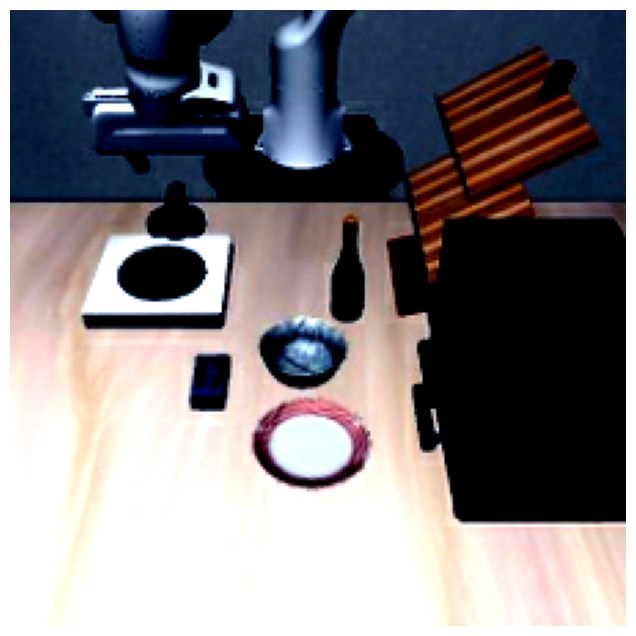

In [20]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

img = data["pixel_values"][0,0:3]  # Shape: [3, 224, 224]
print(img.shape)

# Convert from CHW to HWC format and scale to 0-255 range
img = img.permute(1, 2, 0)  # Shape: [224, 224, 3]
img = (img * 255).clamp(0, 255).to(torch.uint8)


# 将tensor转换为numpy数组并调整通道顺序
img_np = img.numpy()

# 创建新的图形
plt.figure(figsize=(8, 8))
plt.imshow(img_np)
plt.axis('off')  # 不显示坐标轴
plt.show()


torch.Size([3, 224, 224])


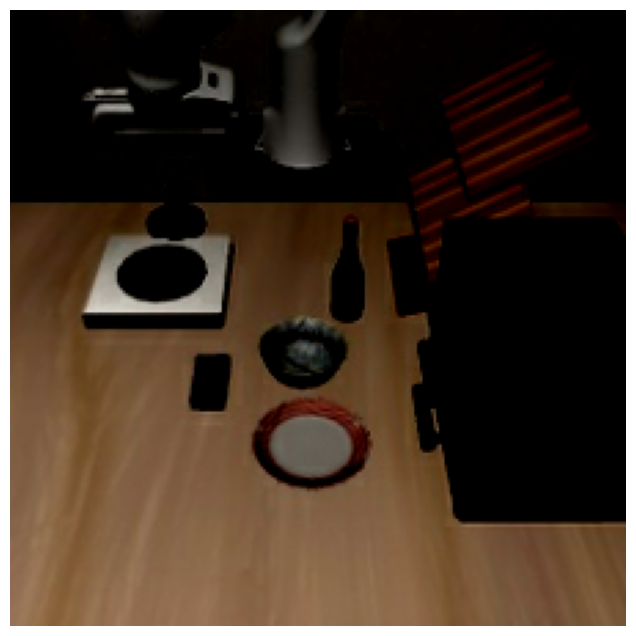

In [21]:
img = data["pixel_values"][0,3:6]  # Shape: [3, 224, 224]
print(img.shape)

# Convert from CHW to HWC format and scale to 0-255 range
img = img.permute(1, 2, 0)  # Shape: [224, 224, 3]
img = (img * 255).clamp(0, 255).to(torch.uint8)


# 将tensor转换为numpy数组并调整通道顺序
img_np = img.numpy()

# 创建新的图形
plt.figure(figsize=(8, 8))
plt.imshow(img_np)
plt.axis('off')  # 不显示坐标轴
plt.show()